In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
from matplotlib import rcParams

rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman"],  # matches Overleaf lmodern
    "mathtext.fontset": "cm",
    "text.latex.preamble": r"\usepackage{lmodern}\usepackage{amsmath}"
})


pd.set_option("display.width", 300)
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', '{:.6f}'.format)

# Load Data

## Load Embeddings

In [148]:
audience_embeddings = pd.read_parquet("NLP Data/Audience Embeddings/rt_audience_embeddings_aggregated.parquet")
critic_embeddings = pd.read_parquet("NLP Data/Critic Embeddings/rt_critic_embeddings_aggregated.parquet")

print(f"Number of movies in audience embeddings data: {audience_embeddings.shape[0]}",
      f"\nNumber of movies in critic embeddings data: {critic_embeddings.shape[0]}")

Number of movies in audience embeddings data: 9116 
Number of movies in critic embeddings data: 9116


## Load Ratings

In [149]:
audience_ratings = pd.concat([pd.read_json(f"Rotten Tomatoes Reviews/Audience Reviews Clean/rt_audience_reviews_clean_{i}.json") for i in range(25)]).groupby("id").agg(AvgAudienceRating = ("ratingOutOfTen", "mean")).reset_index()

critic_ratings = pd.concat([pd.read_json(f"Rotten Tomatoes Reviews/Critic Reviews Clean/rt_critic_reviews_clean_{i}.json") for i in range(20)]).groupby("id").agg(AvgCriticRating = ("ratingOutOfTen", "mean")).reset_index()

print(f"Number of movies in audience rating data: {audience_ratings.shape[0]}",
      f"\nNumber of movies in critic rating data: {critic_ratings.shape[0]}")

Number of movies in audience rating data: 9116 
Number of movies in critic rating data: 9116


## Load 'Movies' Data

In [150]:
movies = pd.read_json("Rotten Tomatoes Reviews/rt_movies_clean.json")

# Merge 'Audience' and 'Critic' Datasets

## Merge 'Audience' and 'Critic' Embeddings

In [151]:
combined_embeddings = pd.merge(left=audience_embeddings.rename(columns={"embeddings": "AudienceEmbeddings"}),
                    right=critic_embeddings.rename(columns={"embeddings": "CriticEmbeddings"}),
                    on="id",
                    how="outer")
combined_embeddings.set_index("id", inplace=True)
combined_embeddings.sort_index(inplace=True)

print(f"Number of rows in combined_embeddings: {combined_embeddings.shape[0]}")
combined_embeddings.head()

Number of rows in combined_embeddings: 9116


,AudienceEmbeddings,CriticEmbeddings
id,,
10000_bc,"[-0.03942528087599016, 0.0032700514138010463, ...","[-0.029380889835797338, 0.013254167158585324, ..."
1000218-accident,"[-0.02399500713051696, -0.0307859453792584, -0...","[-0.00709496159106493, -0.020565725524128147, ..."
10002516-lost_city,"[-0.03502643047207676, 0.010035118767642416, -...","[-0.006343667547931729, -0.007982953772821192,..."
10002635-bridge_of_san_luis_rey,"[-0.01785140314605087, -0.025767731200903653, ...","[-0.014915107875519121, -0.009466946428195419,..."
10003276-criminal,"[-0.052772209397953705, -0.027951262337912338,...","[-0.036120476975689784, -0.0379468278341188, -..."


## Merge 'Audience' and 'Critic' Rating Data

In [152]:
combined_ratings = pd.merge(left=audience_ratings,
                            right=critic_ratings,
                             on="id",
                             how="outer")
combined_ratings.set_index("id", inplace=True)
combined_ratings.sort_index(inplace=True)

print(f"Number of rows in combined_ratings: {combined_ratings.shape[0]}")
combined_ratings.head()

Number of rows in combined_ratings: 9116


,AvgAudienceRating,AvgCriticRating
id,,
10000_bc,4.710843,3.503401
1000218-accident,7.642857,7.772727
10002516-lost_city,7.020000,4.964423
10002635-bridge_of_san_luis_rey,5.900000,3.196429
10003276-criminal,6.556000,6.510274


# Calculate Divergence/Similarity Metrics

## Calculate Cosine Similarity

In [153]:
combined_embeddings["CosineSimilarity"] = combined_embeddings.apply(lambda row: cosine_similarity([row["AudienceEmbeddings"]], [row["CriticEmbeddings"]])[0][0], axis=1)
combined_embeddings.head()

,AudienceEmbeddings,CriticEmbeddings,CosineSimilarity
id,,,
10000_bc,"[-0.03942528087599016, 0.0032700514138010463, ...","[-0.029380889835797338, 0.013254167158585324, ...",0.902636
1000218-accident,"[-0.02399500713051696, -0.0307859453792584, -0...","[-0.00709496159106493, -0.020565725524128147, ...",0.901405
10002516-lost_city,"[-0.03502643047207676, 0.010035118767642416, -...","[-0.006343667547931729, -0.007982953772821192,...",0.888783
10002635-bridge_of_san_luis_rey,"[-0.01785140314605087, -0.025767731200903653, ...","[-0.014915107875519121, -0.009466946428195419,...",0.810171
10003276-criminal,"[-0.052772209397953705, -0.027951262337912338,...","[-0.036120476975689784, -0.0379468278341188, -...",0.898567


## Create Column Containing Difference of Average Audience and Critic Rating

In [154]:
combined_ratings["RatingDifference"] = (combined_ratings["AvgAudienceRating"] - combined_ratings["AvgCriticRating"]).abs()

combined_ratings.head()

,AvgAudienceRating,AvgCriticRating,RatingDifference
id,,,
10000_bc,4.710843,3.503401,1.207442
1000218-accident,7.642857,7.772727,0.129870
10002516-lost_city,7.020000,4.964423,2.055577
10002635-bridge_of_san_luis_rey,5.900000,3.196429,2.703571
10003276-criminal,6.556000,6.510274,0.045726


# Compartmentalize by Rating and Content Similarity

## Merge Rating and Embeddings data for Grouping

In [155]:
Rat_Con_Total = combined_ratings.merge(combined_embeddings, on="id", how="inner")[["RatingDifference", "CosineSimilarity"]]

print(f"Total Rows: {Rat_Con_Total.shape[0]}")
Rat_Con_Total

Total Rows: 9116


,RatingDifference,CosineSimilarity
id,,
10000_bc,1.207442,0.902636
1000218-accident,0.129870,0.901405
10002516-lost_city,2.055577,0.888783
10002635-bridge_of_san_luis_rey,2.703571,0.810171
10003276-criminal,0.045726,0.898567
...,...,...
zoo,0.822417,0.904870
zookeeper,1.867250,0.904950
zoolander,0.984000,0.906266


## Compartmentalise Data into Groups Based on Rating Difference and Review Content Divergence

In [156]:
cutoff = 0.25

# Similar Rating and Similar Review Content
sameRat_sameCon = Rat_Con_Total[(Rat_Con_Total["RatingDifference"] <= Rat_Con_Total["RatingDifference"].quantile(cutoff)) &
                                (Rat_Con_Total["CosineSimilarity"] > Rat_Con_Total["CosineSimilarity"].quantile(1-cutoff))]

# Similar Rating but Diverging Review Content
sameRat_diffCon = Rat_Con_Total[(Rat_Con_Total["RatingDifference"] <= Rat_Con_Total["RatingDifference"].quantile(cutoff)) &
                                (Rat_Con_Total["CosineSimilarity"] <= Rat_Con_Total["CosineSimilarity"].quantile(cutoff))]

# Different Rating but Similar Review Content
diffRat_sameCon = Rat_Con_Total[(Rat_Con_Total["RatingDifference"] > Rat_Con_Total["RatingDifference"].quantile(1-cutoff)) &
                                (Rat_Con_Total["CosineSimilarity"] > Rat_Con_Total["CosineSimilarity"].quantile(1-cutoff))]

# Different Rating and Diverging Review Content
diffRat_diffCon = Rat_Con_Total[(Rat_Con_Total["RatingDifference"] > Rat_Con_Total["RatingDifference"].quantile(1-cutoff)) &
                                (Rat_Con_Total["CosineSimilarity"] <= Rat_Con_Total["CosineSimilarity"].quantile(cutoff))]

## Group Sizes

In [157]:
print(f"Number of Movies with Similar Rating, Similar Review Content: {sameRat_sameCon.shape[0]}",
      f"\nNumber of Movies with Similar Rating, Diverging Review Content: {sameRat_diffCon.shape[0]}",
      f"\nNumber of Movies with Different Rating, Similar Review Content: {diffRat_sameCon.shape[0]}",
      f"\nNumber of Movies with Different Rating, Diverging Review Content: {diffRat_diffCon.shape[0]}")

Number of Movies with Similar Rating, Similar Review Content: 824 
Number of Movies with Similar Rating, Diverging Review Content: 371 
Number of Movies with Different Rating, Similar Review Content: 183 
Number of Movies with Different Rating, Diverging Review Content: 992


# Group Characteristics

## Descriptive Statistics

### Similar Rating, Similar Content

In [158]:
sameRat_sameCon = sameRat_sameCon.merge(right=movies, on="id", how="left")

sameRat_sameCon.describe(include="all")

,id,RatingDifference,CosineSimilarity,title,audienceScore,tomatoMeter,ageRating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,releaseYear,boxOffice
count,824,824.000000,824.000000,824,824.000000,823.000000,591,824,785,815,822.000000,822,822,824,822.000000,824.000000
unique,824,NaN,NaN,821,NaN,NaN,4,512,640,583,NaN,217,34,612,NaN,NaN
top,10005499-oliver_twist,NaN,NaN,Beauty and the Beast,NaN,NaN,R,[],2012-04-27T00:00:00.000,2011-05-10T00:00:00.000,NaN,[Drama],English,Woody Allen,NaN,NaN
freq,1,NaN,NaN,2,NaN,NaN,369,233,5,5,NaN,128,662,9,NaN,NaN
mean,NaN,0.180788,0.934736,NaN,70.280340,77.651276,NaN,NaN,NaN,NaN,110.017032,NaN,NaN,NaN,2008.148418,33103056.826456
std,NaN,0.107897,0.008607,NaN,17.862790,19.431986,NaN,NaN,NaN,NaN,21.569641,NaN,NaN,NaN,10.310283,61045107.326605
min,NaN,0.000607,0.921767,NaN,15.000000,4.000000,NaN,NaN,NaN,NaN,43.000000,NaN,NaN,NaN,1950.000000,1300.000000
25%,NaN,0.088341,0.927950,NaN,59.000000,69.000000,NaN,NaN,NaN,NaN,95.000000,NaN,NaN,NaN,2005.000000,478150.000000
50%,NaN,0.175060,0.933527,NaN,75.000000,84.000000,NaN,NaN,NaN,NaN,107.000000,NaN,NaN,NaN,2010.000000,5450000.000000
75%,NaN,0.275265,0.940802,NaN,84.000000,92.000000,NaN,NaN,NaN,NaN,120.000000,NaN,NaN,NaN,2015.000000,39750000.000000


### Similar Rating, Diverging Content

In [159]:
sameRat_diffCon = sameRat_diffCon.merge(right=movies, on="id", how="left")

sameRat_diffCon.describe(include="all")

,id,RatingDifference,CosineSimilarity,title,audienceScore,tomatoMeter,ageRating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,releaseYear,boxOffice
count,371,371.000000,371.000000,371,362.000000,370.000000,136,371,313,342,370.000000,371,370,370,365.000000,371.000000
unique,371,NaN,NaN,371,NaN,NaN,3,125,289,305,NaN,84,33,353,NaN,NaN
top,10006490,NaN,NaN,Glastonbury,NaN,NaN,R,[],2015-10-23T00:00:00.000,2005-03-22T00:00:00.000,NaN,[Drama],English,James Toback,NaN,NaN
freq,1,NaN,NaN,1,NaN,NaN,95,235,3,3,NaN,104,254,3,NaN,NaN
mean,NaN,0.182192,0.824953,NaN,61.486188,73.494595,NaN,NaN,NaN,NaN,99.797297,NaN,NaN,NaN,2009.065753,5060320.743935
std,NaN,0.109668,0.071725,NaN,18.476940,21.234814,NaN,NaN,NaN,NaN,17.461518,NaN,NaN,NaN,9.560453,25498204.702878
min,NaN,0.000000,0.182191,NaN,14.000000,5.000000,NaN,NaN,NaN,NaN,39.000000,NaN,NaN,NaN,1968.000000,371.000000
25%,NaN,0.085990,0.818843,NaN,49.000000,63.000000,NaN,NaN,NaN,NaN,90.000000,NaN,NaN,NaN,2003.000000,23050.000000
50%,NaN,0.179586,0.846901,NaN,65.000000,79.000000,NaN,NaN,NaN,NaN,97.000000,NaN,NaN,NaN,2011.000000,67700.000000
75%,NaN,0.273952,0.862147,NaN,76.000000,89.000000,NaN,NaN,NaN,NaN,109.750000,NaN,NaN,NaN,2016.000000,369200.000000


### Different Ratings, Similar Content

In [160]:
diffRat_sameCon = diffRat_sameCon.merge(right=movies, on="id", how="left")

diffRat_sameCon.describe(include="all")

,id,RatingDifference,CosineSimilarity,title,audienceScore,tomatoMeter,ageRating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,releaseYear,boxOffice
count,183,183.000000,183.000000,183,183.000000,183.000000,144,183,177,181,183.000000,183,183,183,183.000000,183.000000
unique,183,NaN,NaN,182,NaN,NaN,3,142,166,169,NaN,84,15,171,NaN,NaN
top,10009274-priest,NaN,NaN,Leviathan,NaN,NaN,R,[],2018-08-24T00:00:00.000,2016-01-26T00:00:00.000,NaN,[Comedy],English,Zack Snyder,NaN,NaN
freq,1,NaN,NaN,2,NaN,NaN,81,39,2,3,NaN,18,163,3,NaN,NaN
mean,NaN,1.768577,0.929942,NaN,62.808743,58.622951,NaN,NaN,NaN,NaN,107.071038,NaN,NaN,NaN,2010.338798,44672110.213115
std,NaN,0.392308,0.006885,NaN,18.904954,29.723726,NaN,NaN,NaN,NaN,18.216958,NaN,NaN,NaN,11.200224,80762173.247870
min,NaN,1.401493,0.921740,NaN,14.000000,2.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,1941.000000,369.000000
25%,NaN,1.485809,0.924927,NaN,48.000000,30.500000,NaN,NaN,NaN,NaN,93.000000,NaN,NaN,NaN,2008.000000,1250000.000000
50%,NaN,1.640066,0.928283,NaN,64.000000,60.000000,NaN,NaN,NaN,NaN,105.000000,NaN,NaN,NaN,2013.000000,13300000.000000
75%,NaN,1.895863,0.933004,NaN,79.500000,87.000000,NaN,NaN,NaN,NaN,118.000000,NaN,NaN,NaN,2017.000000,49350000.000000


### Different Ratings, Diverging Content

In [161]:
diffRat_diffCon = diffRat_diffCon.merge(right=movies, how="left", on="id")

diffRat_diffCon.describe(include="all")

,id,RatingDifference,CosineSimilarity,title,audienceScore,tomatoMeter,ageRating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,releaseYear,boxOffice
count,992,992.000000,992.000000,992,971.000000,991.000000,544,992,902,936,989.000000,990,990,990,979.000000,992.000000
unique,992,NaN,NaN,992,NaN,NaN,4,472,711,709,NaN,200,32,883,NaN,NaN
top,10002635-bridge_of_san_luis_rey,NaN,NaN,The Bridge of San Luis Rey,NaN,NaN,R,[],2017-05-05T00:00:00.000,2004-06-01T00:00:00.000,NaN,[Drama],English,Tyler Perry,NaN,NaN
freq,1,NaN,NaN,1,NaN,NaN,231,448,4,5,NaN,186,811,14,NaN,NaN
mean,NaN,2.346720,0.819224,NaN,64.386200,48.160444,NaN,NaN,NaN,NaN,101.112235,NaN,NaN,NaN,2009.003064,11485080.104839
std,NaN,0.813255,0.064165,NaN,18.356554,28.485819,NaN,NaN,NaN,NaN,15.229836,NaN,NaN,NaN,9.349223,25322225.044168
min,NaN,1.401130,0.248581,NaN,12.000000,0.000000,NaN,NaN,NaN,NaN,46.000000,NaN,NaN,NaN,1941.000000,1000.000000
25%,NaN,1.741798,0.806083,NaN,51.000000,23.000000,NaN,NaN,NaN,NaN,91.000000,NaN,NaN,NaN,2002.000000,45075.000000
50%,NaN,2.114884,0.839730,NaN,65.000000,46.000000,NaN,NaN,NaN,NaN,99.000000,NaN,NaN,NaN,2008.000000,442550.000000
75%,NaN,2.759409,0.857476,NaN,79.000000,71.000000,NaN,NaN,NaN,NaN,109.000000,NaN,NaN,NaN,2017.500000,12500000.000000


## 'Popcorn Meter' Score Distributions

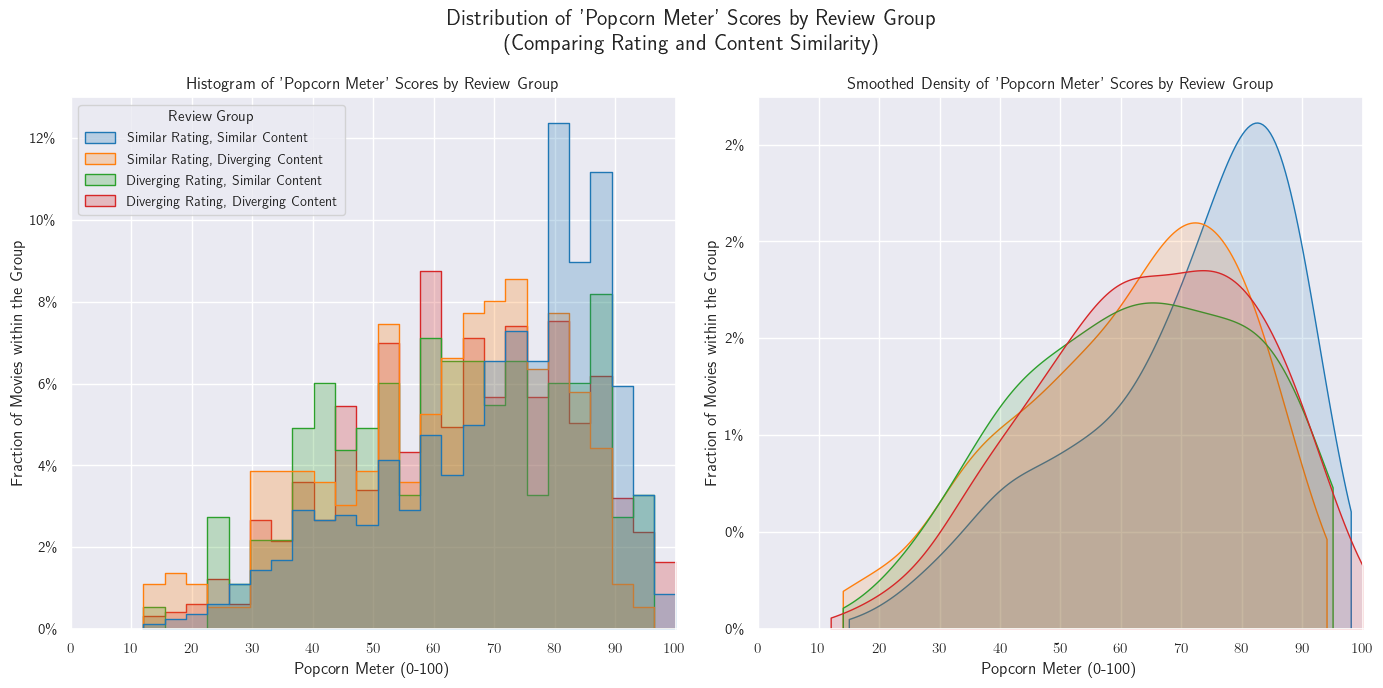

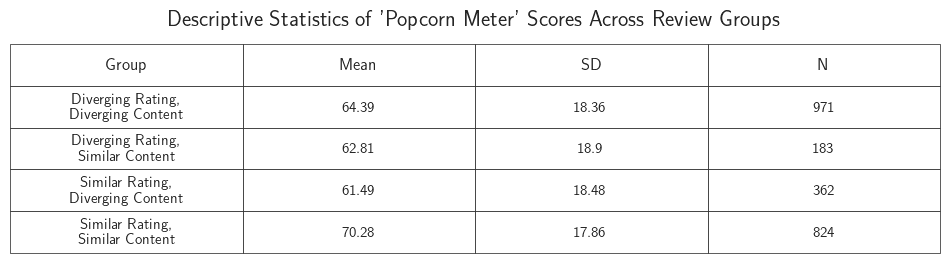

In [162]:
# Combine subsets into a single DataFrame to use "hue" functionality
sameRat_sameCon["group"] = "Similar Rating, Similar Content"
sameRat_diffCon["group"] = "Similar Rating, Diverging Content"
diffRat_sameCon["group"] = "Diverging Rating, Similar Content"
diffRat_diffCon["group"] = "Diverging Rating, Diverging Content"

combined = pd.concat([sameRat_sameCon, sameRat_diffCon, diffRat_sameCon, diffRat_diffCon], ignore_index=True)

# Define consistent color mapping
group_order = [
    "Similar Rating, Similar Content",
    "Similar Rating, Diverging Content",
    "Diverging Rating, Similar Content",
    "Diverging Rating, Diverging Content"
]

palette = sns.color_palette("tab10", n_colors=4)
group_palette = dict(zip(group_order, palette))


sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1,2, figsize=(14,7))
plt.suptitle("Distribution of 'Popcorn Meter' Scores by Review Group\n(Comparing Rating and Content Similarity)", fontweight="bold", fontsize=16)

# Histplot
sns.histplot(data=combined, x="audienceScore", hue="group", bins=25, element="step", stat="probability", common_norm=False, palette=group_palette, ax=axes[0], legend=True)
axes[0].set_title("Histogram of 'Popcorn Meter' Scores by Review Group", fontweight="bold")

# Format the automatically created legend
leg = axes[0].get_legend()
leg.set_title("Review Group")
plt.setp(leg.get_title(), fontsize=11, fontweight="bold")
plt.setp(leg.get_texts(), fontsize=10)

# KDE
for group in combined["group"].unique():
    sns.kdeplot(data=combined[combined["group"] == group], x="audienceScore", color=group_palette[group], bw_adjust=1.2, cut=0, clip=(0, 100), ax=axes[1], fill=True, alpha=0.15)
axes[1].set_title("Smoothed Density of 'Popcorn Meter' Scores by Review Group", fontweight="bold")

# Common styling for Plots
for ax in axes:
    ax.set_xlim(0, 100)
    ax.set_xticks(np.arange(0, 101, 10))
    ax.set_xlabel("Popcorn Meter (0-100)")
    ax.set_ylabel("Fraction of Movies within the Group")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{100*y:.0f}\%'))

plt.tight_layout()
plt.show()

sns.set_theme(style="white")
plt.figure(figsize=(8,3))
plt.axis("off")
plt.title("Descriptive Statistics of 'Popcorn Meter' Scores Across Review Groups", fontweight="bold", fontsize=16)

# Summary Statistics
summary = combined.groupby("group").agg(Mean = ("audienceScore", "mean"),
                                        SD = ("audienceScore", "std"),
                                        N = ("audienceScore", "count")).reset_index().round({"Mean": 2, "SD": 2})
summary["group"] = summary["group"].replace({"Similar Rating, Similar Content": "Similar Rating,\nSimilar Content",
                                             "Similar Rating, Diverging Content": "Similar Rating,\nDiverging Content",
                                             "Diverging Rating, Similar Content": "Diverging Rating,\nSimilar Content",
                                             "Diverging Rating, Diverging Content": "Diverging Rating,\nDiverging Content"})
summary.rename(columns={"group": "Group"}, inplace=True)

# Create Table
table = plt.table(cellText = summary.values,
                      colLabels = summary.columns,
                      loc = "center",
                      cellLoc = "center")
table.scale(1.5, 2.5)

table.auto_set_font_size(False)
table.set_fontsize(11)
for key, cell in table.get_celld().items():
    cell.set_linewidth(0.5)
    if key[0] == 0:
        cell.set_fontsize(12)
        cell.set_text_props(weight="bold")




plt.show()


### Test for Normality

In [163]:
# Test  H₀: distribution is normal
#       H₁: distribution is not normal

stat1, p1 = stats.shapiro(sameRat_sameCon.dropna(subset=["audienceScore"])["audienceScore"])
stat2, p2 = stats.shapiro(sameRat_diffCon.dropna(subset=["audienceScore"])["audienceScore"])
stat3, p3 = stats.shapiro(diffRat_sameCon.dropna(subset=["audienceScore"])["audienceScore"])
stat4, p4 = stats.shapiro(diffRat_diffCon.dropna(subset=["audienceScore"])["audienceScore"])

print(f"Shapiro-Wilk test for normality:",
      f"\nSimilar Rating, Similar Content: {p1:.4f}",
      f"\nSimilar Rating, Diverging Content: {p2:.4f}",
      f"\nDiverging Rating, Similar Content: {p3:.4f}",
      f"\nDiverging Rating, Diverging Content: {p4:.4f}")

Shapiro-Wilk test for normality: 
Similar Rating, Similar Content: 0.0000 
Similar Rating, Diverging Content: 0.0000 
Diverging Rating, Similar Content: 0.0008 
Diverging Rating, Diverging Content: 0.0000


### Test for Log-Normality

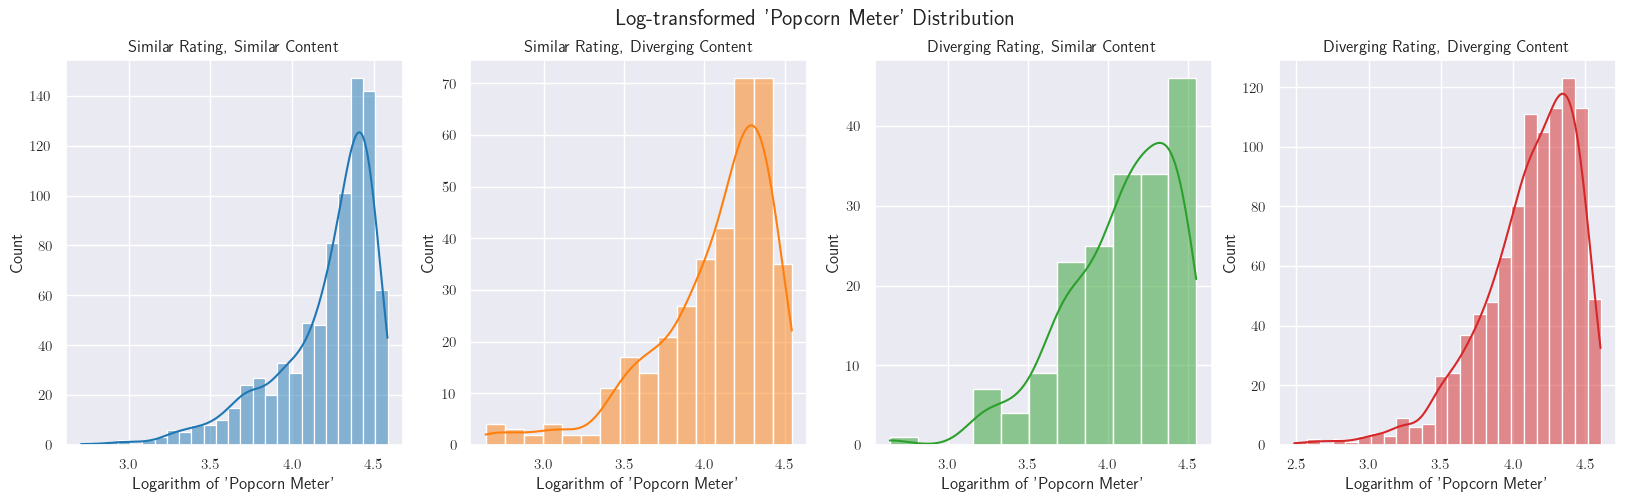

Shapiro-Wilk test for lognormality: 
Similar Rating, Similar Content: 0.0000 
Similar Rating, Diverging Content: 0.0000 
Diverging Rating, Similar Content: 0.0000 
Diverging Rating, Diverging Content: 0.0000


In [164]:
# Test  H₀: distribution is log-normal
#       H₁: distribution is not log-normal

sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1,4, figsize=(20,5))
plt.suptitle("Log-transformed 'Popcorn Meter' Distribution", fontweight="bold", fontsize=16)

log_values1 = np.log(sameRat_sameCon.dropna(subset=["audienceScore"])["audienceScore"])
sns.histplot(log_values1, kde=True, ax=axes[0], color=group_palette["Similar Rating, Similar Content"])
axes[0].set_xlabel("Logarithm of 'Popcorn Meter'")
axes[0].set_title("Similar Rating, Similar Content")

log_values2 = np.log(sameRat_diffCon.dropna(subset=["audienceScore"])["audienceScore"])
sns.histplot(log_values2, kde=True, ax=axes[1], color=group_palette["Similar Rating, Diverging Content"])
axes[1].set_xlabel("Logarithm of 'Popcorn Meter'")
axes[1].set_title("Similar Rating, Diverging Content")

log_values3 = np.log(diffRat_sameCon.dropna(subset=["audienceScore"])["audienceScore"])
sns.histplot(log_values3, kde=True, ax=axes[2], color=group_palette["Diverging Rating, Similar Content"])
axes[2].set_xlabel("Logarithm of 'Popcorn Meter'")
axes[2].set_title("Diverging Rating, Similar Content")

log_values4 = np.log(diffRat_diffCon.dropna(subset=["audienceScore"])["audienceScore"])
sns.histplot(log_values4, kde=True, ax=axes[3], color=group_palette["Diverging Rating, Diverging Content"])
axes[3].set_xlabel("Logarithm of 'Popcorn Meter'")
axes[3].set_title("Diverging Rating, Diverging Content")

plt.show()

# Test for normality (lognormality implies this should be ~normal)
stat1, p1 = stats.shapiro(log_values1)
stat2, p2 = stats.shapiro(log_values2)
stat3, p3 = stats.shapiro(log_values3)
stat4, p4 = stats.shapiro(log_values4)

print(f"Shapiro-Wilk test for lognormality:",
      f"\nSimilar Rating, Similar Content: {p1:.4f}",
      f"\nSimilar Rating, Diverging Content: {p2:.4f}",
      f"\nDiverging Rating, Similar Content: {p3:.4f}",
      f"\nDiverging Rating, Diverging Content: {p4:.4f}")


### Kruskal-Wallis H-Test (Test if the Distributions differ from each other)

In [165]:
# Test  H₀: distributions are identical
#       H₁: at least one distribution differs

groups = [g["audienceScore"].dropna() for _, g in combined.groupby("group")]
H, p = stats.kruskal(*groups)
print(f"Kruskal–Wallis H = {H:.3f}, p = {p:.4f}")

Kruskal–Wallis H = 87.878, p = 0.0000


### Pairwise Mann-Whitney U-Tests

In [166]:
# Test  H₀: distributions are identical
#       H₁: distribution differ from each other

groups_dict = {name: g["audienceScore"].dropna() for name, g in combined.groupby("group")}

pairs = []
for (g1, g2) in combinations(groups_dict.keys(), 2):
    u, p = stats.mannwhitneyu(groups_dict[g1], groups_dict[g2], alternative='two-sided')
    pairs.append([g1, g2, u, p])

results = pd.DataFrame(pairs, columns=["Group 1", "Group 2", "U-statistic", "p-value"])
results["p (Bonferroni)"] = results["p-value"] * len(results)
results["Significant"] = results["p (Bonferroni)"] < 0.05
print(results)

                               Group 1                            Group 2   U-statistic  p-value  p (Bonferroni)  Significant
0  Diverging Rating, Diverging Content  Diverging Rating, Similar Content  92843.000000 0.333853        2.003116        False
1  Diverging Rating, Diverging Content  Similar Rating, Diverging Content 189230.000000 0.031043        0.186259        False
2  Diverging Rating, Diverging Content    Similar Rating, Similar Content 319457.000000 0.000000        0.000000         True
3    Diverging Rating, Similar Content  Similar Rating, Diverging Content  34242.000000 0.519351        3.116104        False
4    Diverging Rating, Similar Content    Similar Rating, Similar Content  57720.000000 0.000001        0.000004         True
5    Similar Rating, Diverging Content    Similar Rating, Similar Content 105679.500000 0.000000        0.000000         True


In [167]:
# Test  H₀: distributions are identical
#       H₁: distribution differ from each other

groups_dict = {name: g["audienceScore"].dropna() for name, g in combined.groupby("group")}

pairs = []
for (g1, g2) in combinations(groups_dict.keys(), 2):
    u, p = stats.mannwhitneyu(groups_dict[g1], groups_dict[g2], alternative='two-sided')
    pairs.append([g1, g2, u, p])

results = pd.DataFrame(pairs, columns=["Group 1", "Group 2", "U-statistic", "p-value"])
results["p (Bonferroni)"] = results["p-value"] * len(results)
results["Significant"] = results["p (Bonferroni)"] < 0.05
print(results)

                               Group 1                            Group 2   U-statistic  p-value  p (Bonferroni)  Significant
0  Diverging Rating, Diverging Content  Diverging Rating, Similar Content  92843.000000 0.333853        2.003116        False
1  Diverging Rating, Diverging Content  Similar Rating, Diverging Content 189230.000000 0.031043        0.186259        False
2  Diverging Rating, Diverging Content    Similar Rating, Similar Content 319457.000000 0.000000        0.000000         True
3    Diverging Rating, Similar Content  Similar Rating, Diverging Content  34242.000000 0.519351        3.116104        False
4    Diverging Rating, Similar Content    Similar Rating, Similar Content  57720.000000 0.000001        0.000004         True
5    Similar Rating, Diverging Content    Similar Rating, Similar Content 105679.500000 0.000000        0.000000         True


## Tomato Meter Distributions

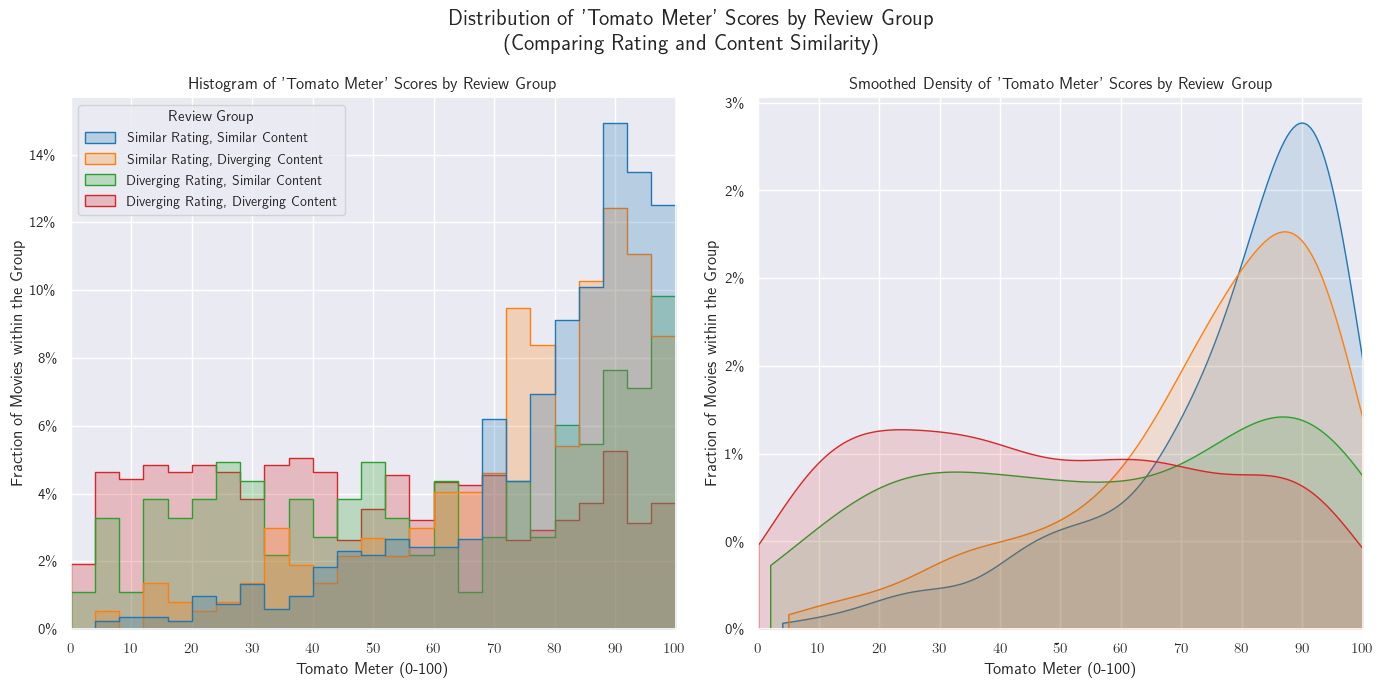

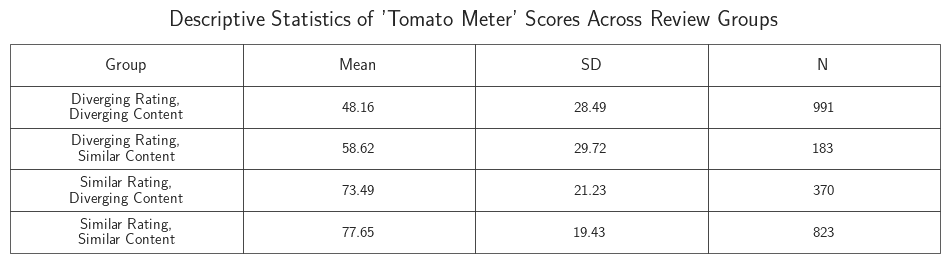

In [168]:
sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1,2, figsize=(14,7))
plt.suptitle("Distribution of 'Tomato Meter' Scores by Review Group\n(Comparing Rating and Content Similarity)", fontweight="bold", fontsize=16)

# Histplot
sns.histplot(data=combined, x="tomatoMeter", hue="group", bins=25, element="step", stat="probability", common_norm=False, palette=group_palette, ax=axes[0], legend=True)
axes[0].set_title("Histogram of 'Tomato Meter' Scores by Review Group", fontweight="bold")

# Format the automatically created legend
leg = axes[0].get_legend()
leg.set_title("Review Group")
plt.setp(leg.get_title(), fontsize=11, fontweight="bold")
plt.setp(leg.get_texts(), fontsize=10)

# KDE
for group in combined["group"].unique():
    sns.kdeplot(data=combined[combined["group"] == group], x="tomatoMeter", color=group_palette[group], bw_adjust=1.2, cut=0, clip=(0, 100), ax=axes[1], fill=True, alpha=0.15)
axes[1].set_title("Smoothed Density of 'Tomato Meter' Scores by Review Group", fontweight="bold")

# Common styling
for ax in axes:
    ax.set_xlim(0, 100)
    ax.set_xticks(np.arange(0, 101, 10))
    ax.set_xlabel("Tomato Meter (0-100)")
    ax.set_ylabel("Fraction of Movies within the Group")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{100*y:.0f}\%'))

plt.tight_layout()
plt.show()

sns.set_theme(style="white")
plt.figure(figsize=(8,3))
plt.axis("off")
plt.title("Descriptive Statistics of 'Tomato Meter' Scores Across Review Groups", fontweight="bold", fontsize=16)

# Summary Statistics
summary = combined.groupby("group").agg(Mean = ("tomatoMeter", "mean"),
                                        SD = ("tomatoMeter", "std"),
                                        N = ("tomatoMeter", "count")).reset_index().round({"Mean": 2, "SD": 2})
summary["group"] = summary["group"].replace({"Similar Rating, Similar Content": "Similar Rating,\nSimilar Content",
                                             "Similar Rating, Diverging Content": "Similar Rating,\nDiverging Content",
                                             "Diverging Rating, Similar Content": "Diverging Rating,\nSimilar Content",
                                             "Diverging Rating, Diverging Content": "Diverging Rating,\nDiverging Content"})
summary.rename(columns={"group": "Group"}, inplace=True)

# Create Table
table = plt.table(cellText = summary.values,
                      colLabels = summary.columns,
                      loc = "center",
                      cellLoc = "center")
table.scale(1.5, 2.5)

table.auto_set_font_size(False)
table.set_fontsize(11)
for key, cell in table.get_celld().items():
    cell.set_linewidth(0.5)
    if key[0] == 0:
        cell.set_fontsize(12)
        cell.set_text_props(weight="bold")


plt.show()

### Test for Normality

In [169]:
# Test  H₀: distribution is normal
#       H₁: distribution is not normal

stat1, p1 = stats.shapiro(sameRat_sameCon.dropna(subset=["tomatoMeter"])["tomatoMeter"])
stat2, p2 = stats.shapiro(sameRat_diffCon.dropna(subset=["tomatoMeter"])["tomatoMeter"])
stat3, p3 = stats.shapiro(diffRat_sameCon.dropna(subset=["tomatoMeter"])["tomatoMeter"])
stat4, p4 = stats.shapiro(diffRat_diffCon.dropna(subset=["tomatoMeter"])["tomatoMeter"])

print(f"Shapiro-Wilk test for normality:",
      f"\nSimilar Rating, Similar Content: {p1:.4f}",
      f"\nSimilar Rating, Diverging Content: {p2:.4f}",
      f"\nDiverging Rating, Similar Content: {p3:.4f}",
      f"\nDiverging Rating, Diverging Content: {p4:.4f}")

Shapiro-Wilk test for normality: 
Similar Rating, Similar Content: 0.0000 
Similar Rating, Diverging Content: 0.0000 
Diverging Rating, Similar Content: 0.0000 
Diverging Rating, Diverging Content: 0.0000


### Test for Log-Normality

/Users/renatoromagna/Desktop/UZH/Masterarbeit/Master's Thesis Code/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


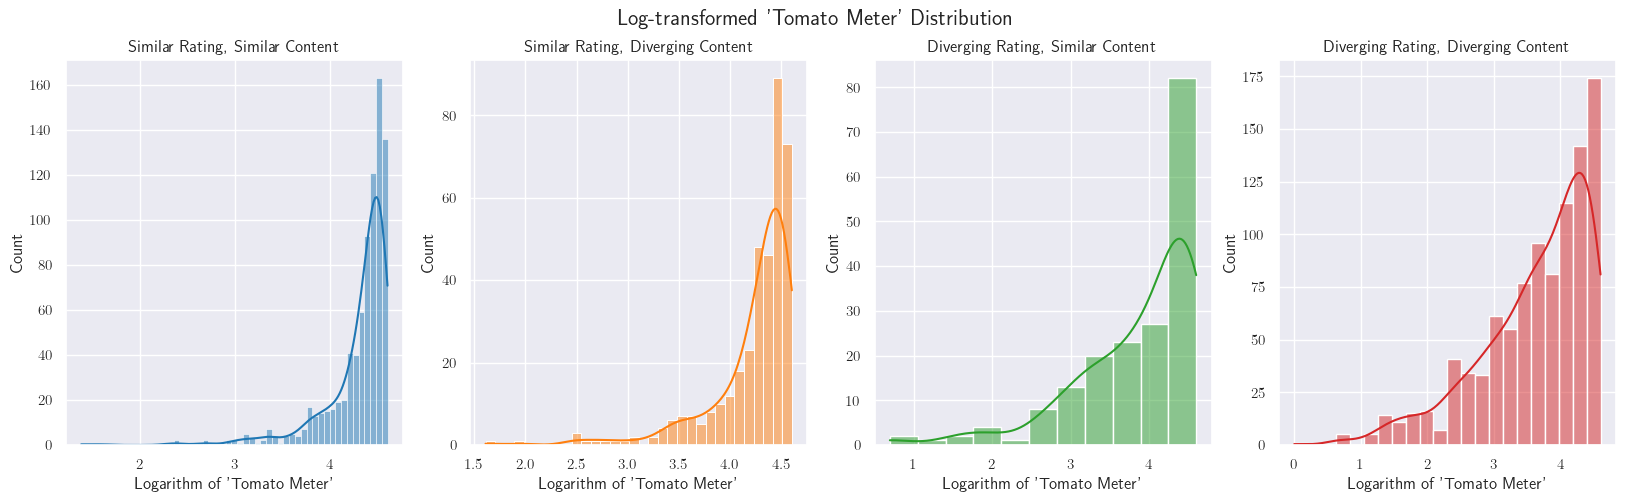

Shapiro-Wilk test for lognormality: 
Similar Rating, Similar Content: 0.0000 
Similar Rating, Diverging Content: 0.0000 
Diverging Rating, Similar Content: 0.0000 
Diverging Rating, Diverging Content: 1.0000


In [170]:
# Test  H₀: distribution is log-normal
#       H₁: distribution is not log-normal

sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1,4, figsize=(20,5))
plt.suptitle("Log-transformed 'Tomato Meter' Distribution", fontweight="bold", fontsize=16)

log_values1 = np.log(sameRat_sameCon.dropna(subset=["tomatoMeter"])["tomatoMeter"])
sns.histplot(log_values1, kde=True, ax=axes[0], color=group_palette["Similar Rating, Similar Content"])
axes[0].set_xlabel("Logarithm of 'Tomato Meter'")
axes[0].set_title("Similar Rating, Similar Content")

log_values2 = np.log(sameRat_diffCon.dropna(subset=["tomatoMeter"])["tomatoMeter"])
sns.histplot(log_values2, kde=True, ax=axes[1], color=group_palette["Similar Rating, Diverging Content"])
axes[1].set_xlabel("Logarithm of 'Tomato Meter'")
axes[1].set_title("Similar Rating, Diverging Content")

log_values3 = np.log(diffRat_sameCon.dropna(subset=["tomatoMeter"])["tomatoMeter"])
sns.histplot(log_values3, kde=True, ax=axes[2], color=group_palette["Diverging Rating, Similar Content"])
axes[2].set_xlabel("Logarithm of 'Tomato Meter'")
axes[2].set_title("Diverging Rating, Similar Content")

log_values4 = np.log(diffRat_diffCon.dropna(subset=["tomatoMeter"])["tomatoMeter"])
sns.histplot(log_values4, kde=True, ax=axes[3], color=group_palette["Diverging Rating, Diverging Content"])
axes[3].set_xlabel("Logarithm of 'Tomato Meter'")
axes[3].set_title("Diverging Rating, Diverging Content")

plt.show()

# Test for normality (lognormality implies this should be ~normal)
stat1, p1 = stats.shapiro(log_values1)
stat2, p2 = stats.shapiro(log_values2)
stat3, p3 = stats.shapiro(log_values3)
stat4, p4 = stats.shapiro(log_values4)

print(f"Shapiro-Wilk test for lognormality:",
      f"\nSimilar Rating, Similar Content: {p1:.4f}",
      f"\nSimilar Rating, Diverging Content: {p2:.4f}",
      f"\nDiverging Rating, Similar Content: {p3:.4f}",
      f"\nDiverging Rating, Diverging Content: {p4:.4f}")


### Kruskal-Wallis H-Test (Test if the Distributions differ from each other)

In [171]:
# Test  H₀: distributions are identical
#       H₁: at least one distribution differs

groups = [group["tomatoMeter"].dropna() for _, group in combined.groupby("group")]
H, p = stats.kruskal(*groups)
print(f"Kruskal–Wallis H = {H:.3f}, p = {p:.4f}")

Kruskal–Wallis H = 517.250, p = 0.0000


### Pairwise Mann-Whitney U-Tests

In [172]:
# Test  H₀: distributions are identical
#       H₁: distribution differ from each other

groups_dict = {name: group["tomatoMeter"].dropna() for name, group in combined.groupby("group")}

pairs = []
for (g1, g2) in combinations(groups_dict.keys(), 2):
    u, p = stats.mannwhitneyu(groups_dict[g1], groups_dict[g2], alternative='two-sided')
    pairs.append([g1, g2, u, p])

results = pd.DataFrame(pairs, columns=["Group 1", "Group 2", "U-statistic", "p-value"])
results["p (Bonferroni)"] = results["p-value"] * len(results)
results["Significant"] = results["p (Bonferroni)"] < 0.05
print(results)

                               Group 1                            Group 2   U-statistic  p-value  p (Bonferroni)  Significant
0  Diverging Rating, Diverging Content  Diverging Rating, Similar Content  71800.000000 0.000007        0.000045         True
1  Diverging Rating, Diverging Content  Similar Rating, Diverging Content  90674.000000 0.000000        0.000000         True
2  Diverging Rating, Diverging Content    Similar Rating, Similar Content 169370.500000 0.000000        0.000000         True
3    Diverging Rating, Similar Content  Similar Rating, Diverging Content  24942.000000 0.000000        0.000003         True
4    Diverging Rating, Similar Content    Similar Rating, Similar Content  48764.500000 0.000000        0.000000         True
5    Similar Rating, Diverging Content    Similar Rating, Similar Content 133041.500000 0.000480        0.002882         True


## Box Office Distributions

### Box Office Distributions

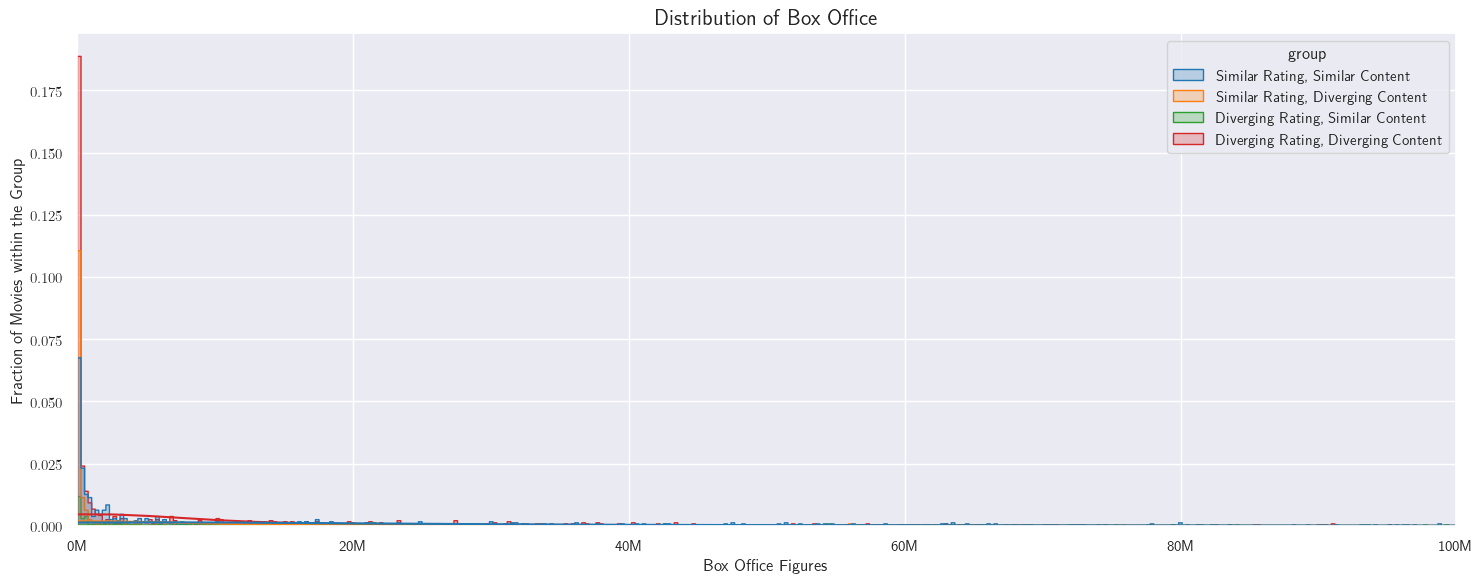

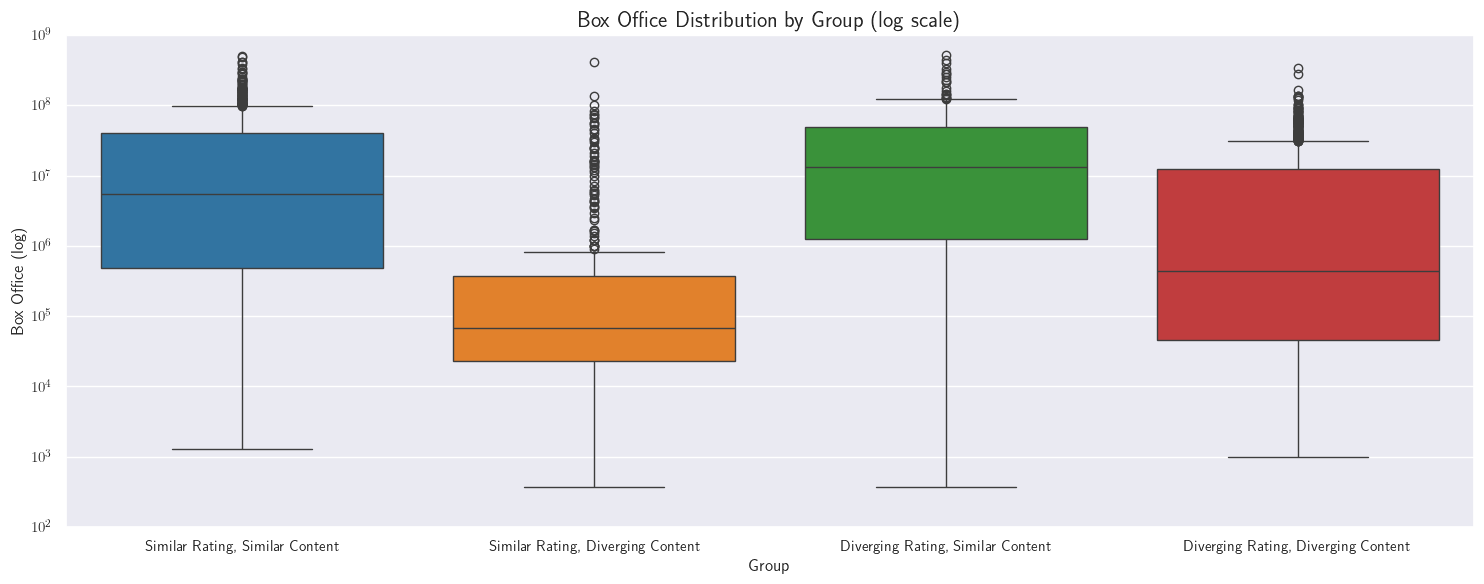

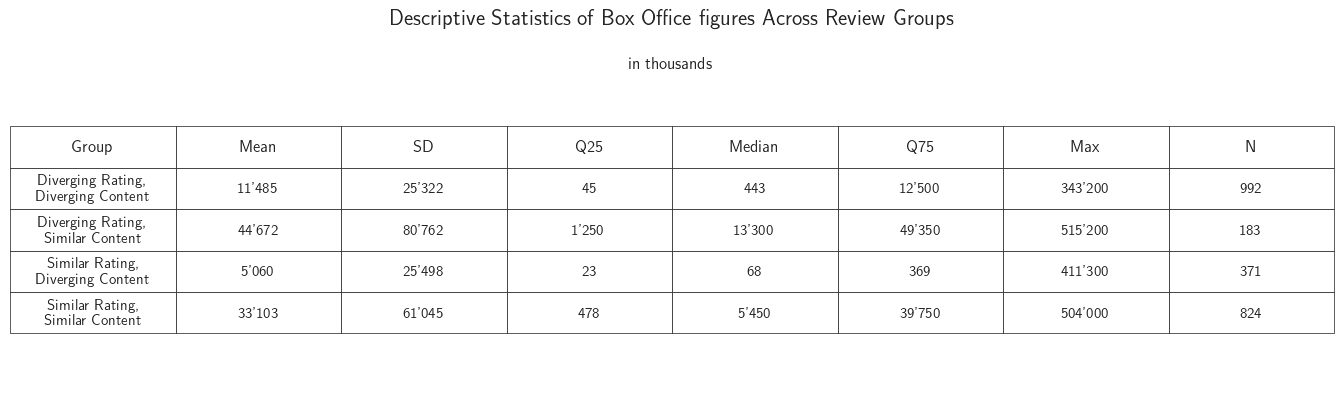

In [173]:
sns.set_theme(style="darkgrid")
# Histogram
fig, ax = plt.subplots(figsize=(15, 6))
sns.histplot(data=combined , x="boxOffice", bins = 2000, hue="group", stat="probability", element="step", palette=group_palette, kde=True, ax=ax)
ax.set_title("Distribution of Box Office", fontweight="bold", fontsize=16)
ax.set_ylabel("Fraction of Movies within the Group")
ax.set_xlabel("Box Office Figures")
ax.set_xlim((0,100000000))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x/1000000):,}M".replace(",", "'")))

plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(15, 6))
sns.boxplot(data=combined, x="group", y="boxOffice", hue="group", palette=group_palette)
plt.yscale("log")
plt.title("Box Office Distribution by Group (log scale)", fontweight = "bold", fontsize=16)
plt.xlabel("Group")
plt.ylabel("Box Office (log)")
plt.ylim((100, 1000000000))

plt.tight_layout()
plt.show()

sns.set_theme(style="white")
plt.figure(figsize=(15,4))
plt.axis("off")
plt.suptitle("Descriptive Statistics of Box Office figures Across Review Groups", fontweight="bold", fontsize=16)
plt.title("in thousands", fontsize=12)

# Summary Statistics
summary = combined.groupby("group").agg(Mean = ("boxOffice", "mean"),
                                        SD = ("boxOffice", "std"),
                                        Q25 = ("boxOffice", lambda x: x.quantile(0.25)),
                                        Median = ("boxOffice", lambda x: x.quantile(0.5)),
                                        Q75 = ("boxOffice", lambda x: x.quantile(0.75)),
                                        Max = ("boxOffice", "max"),
                                        N = ("boxOffice", "count")).reset_index().round({"Mean": 2, "SD": 2, "Q25": 2, "Median": 2, "Q75": 2, "Max": 0})

summary["group"] = summary["group"].replace({"Similar Rating, Similar Content": "Similar Rating,\nSimilar Content",
                                             "Similar Rating, Diverging Content": "Similar Rating,\nDiverging Content",
                                             "Diverging Rating, Similar Content": "Diverging Rating,\nSimilar Content",
                                             "Diverging Rating, Diverging Content": "Diverging Rating,\nDiverging Content"})
summary.rename(columns={"group": "Group"}, inplace=True)

# Format Numbers
def format_k(x):
    """Convert numbers to 'x' K format with apostrophes, e.g., 10'000 K"""
    return f"{x/1000:,.0f}".replace(",", "'")

for col in ["Mean", "SD", "Q25", "Median", "Q75", "Max"]:
    summary[col] = summary[col].apply(format_k)

# Create Table
table = plt.table(cellText = summary.values,
                      colLabels = summary.columns,
                      loc = "center",
                      cellLoc = "center")
table.scale(1.5, 2.5)

table.auto_set_font_size(False)
table.set_fontsize(11)
for key, cell in table.get_celld().items():
    cell.set_linewidth(0.5)
    if key[0] == 0:
        cell.set_fontsize(12)
        cell.set_text_props(weight="bold")

plt.tight_layout()
plt.show()

### Test for Log-Normality

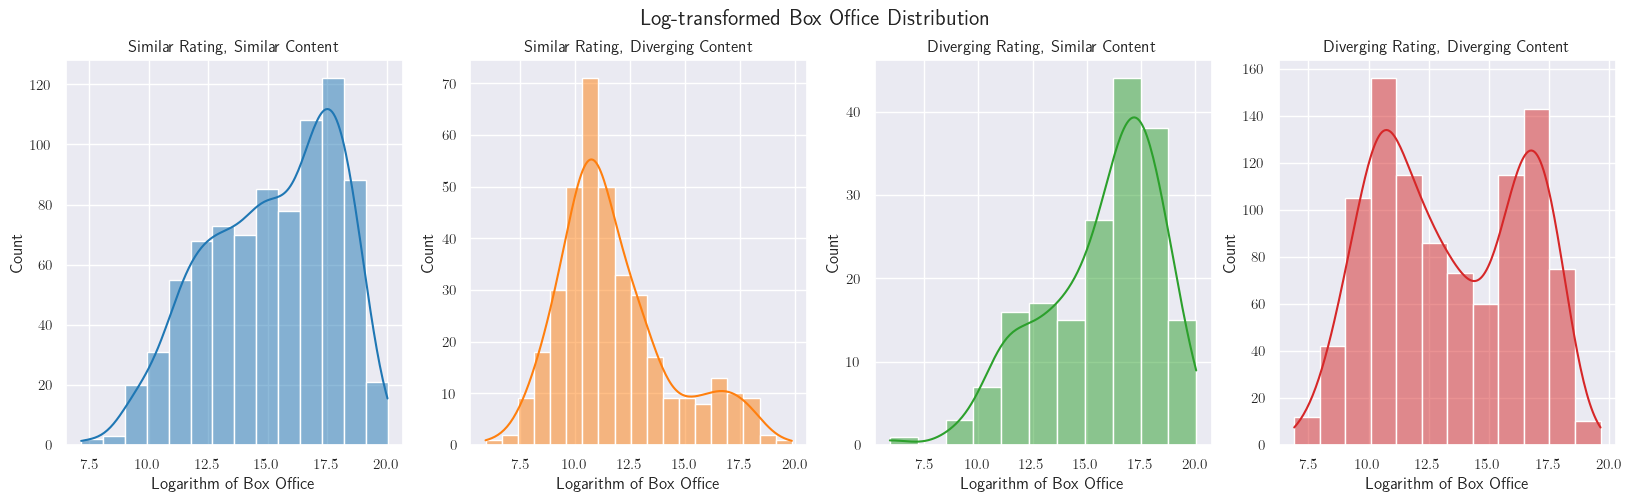

Shapiro-Wilk test for lognormality: 
Similar Rating, Similar Content: 0.0000 
Similar Rating, Diverging Content: 0.0000 
Diverging Rating, Similar Content: 0.0000 
Diverging Rating, Diverging Content: 0.0000


In [174]:
sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1,4, figsize=(20,5))
plt.suptitle("Log-transformed Box Office Distribution", fontweight="bold", fontsize=16)

log_values1 = np.log(sameRat_sameCon["boxOffice"])
sns.histplot(log_values1, kde=True, ax=axes[0], color=group_palette["Similar Rating, Similar Content"])
axes[0].set_xlabel("Logarithm of Box Office")
axes[0].set_title("Similar Rating, Similar Content")

log_values2 = np.log(sameRat_diffCon["boxOffice"])
sns.histplot(log_values2, kde=True, ax=axes[1], color=group_palette["Similar Rating, Diverging Content"])
axes[1].set_xlabel("Logarithm of Box Office")
axes[1].set_title("Similar Rating, Diverging Content")

log_values3 = np.log(diffRat_sameCon["boxOffice"])
sns.histplot(log_values3, kde=True, ax=axes[2], color=group_palette["Diverging Rating, Similar Content"])
axes[2].set_xlabel("Logarithm of Box Office")
axes[2].set_title("Diverging Rating, Similar Content")

log_values4 = np.log(diffRat_diffCon["boxOffice"])
sns.histplot(log_values4, kde=True, ax=axes[3], color=group_palette["Diverging Rating, Diverging Content"])
axes[3].set_xlabel("Logarithm of Box Office")
axes[3].set_title("Diverging Rating, Diverging Content")

plt.show()

# Test for normality (lognormality implies this should be ~normal)
stat1, p1 = stats.shapiro(log_values1)
stat2, p2 = stats.shapiro(log_values2)
stat3, p3 = stats.shapiro(log_values3)
stat4, p4 = stats.shapiro(log_values4)

print(f"Shapiro-Wilk test for lognormality:",
      f"\nSimilar Rating, Similar Content: {p1:.4f}",
      f"\nSimilar Rating, Diverging Content: {p2:.4f}",
      f"\nDiverging Rating, Similar Content: {p3:.4f}",
      f"\nDiverging Rating, Diverging Content: {p4:.4f}")


### Kruskal-Wallis H-Test (Test if the Distributions differ from each other)

In [175]:
# Test  H₀: distributions are identical
#       H₁: at least one distribution differs
groups = [g["boxOffice"].dropna() for _, g in combined.groupby("group")]
H, p = stats.kruskal(*groups)
print(f"Kruskal–Wallis H = {H:.3f}, p = {p:.4f}")

Kruskal–Wallis H = 416.492, p = 0.0000


### Pairwise Mann-Whitney U-Tests

In [176]:
# Test  H₀: distributions are identical
#       H₁: distribution differ from each other

groups_dict = {name: g["boxOffice"].dropna() for name, g in combined.groupby("group")}

pairs = []
for (g1, g2) in combinations(groups_dict.keys(), 2):
    u, p = stats.mannwhitneyu(groups_dict[g1], groups_dict[g2], alternative='two-sided')
    pairs.append([g1, g2, u, p])

results = pd.DataFrame(pairs, columns=["Group 1", "Group 2", "U-statistic", "p-value"])
results["p (Bonferroni)"] = results["p-value"] * len(results)
results["Significant"] = results["p (Bonferroni)"] < 0.05
print(results)

                               Group 1                            Group 2   U-statistic  p-value  p (Bonferroni)  Significant
0  Diverging Rating, Diverging Content  Diverging Rating, Similar Content  51330.000000 0.000000        0.000000         True
1  Diverging Rating, Diverging Content  Similar Rating, Diverging Content 240427.000000 0.000000        0.000000         True
2  Diverging Rating, Diverging Content    Similar Rating, Similar Content 268136.000000 0.000000        0.000000         True
3    Diverging Rating, Similar Content  Similar Rating, Diverging Content  57873.000000 0.000000        0.000000         True
4    Diverging Rating, Similar Content    Similar Rating, Similar Content  83755.000000 0.018846        0.113078        False
5    Similar Rating, Diverging Content    Similar Rating, Similar Content  53881.000000 0.000000        0.000000         True


# Thesis Plots

## Valence

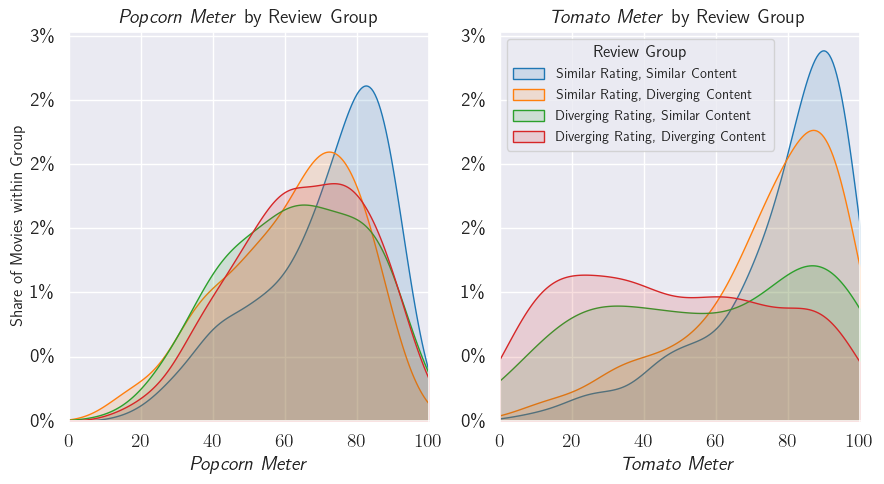

In [187]:
fig, axes = plt.subplots(1,2, figsize=(9,5), sharex=True, sharey=True)
sns.set_theme(style="darkgrid")

# KDE Popcorn Meter
for group in combined["group"].unique():
    sns.kdeplot(data=combined[combined["group"] == group], x="audienceScore", color=group_palette[group], bw_adjust=1.2, clip=(0, 100), ax=axes[0], fill=True, alpha=0.15, label=group)
axes[0].set_title("\emph{Popcorn Meter} by Review Group", fontweight="bold", fontsize=14)
axes[0].set_xlabel("\emph{Popcorn Meter}", fontsize=14)

# KDE Tomato Meter
for group in combined["group"].unique():
    sns.kdeplot(data=combined[combined["group"] == group], x="tomatoMeter", color=group_palette[group], bw_adjust=1.2, clip=(0, 100), ax=axes[1], fill=True, alpha=0.15, label=group)
axes[1].set_title("\emph{Tomato Meter} by Review Group", fontweight="bold", fontsize=14)
axes[1].set_xlabel("\emph{Tomato Meter}", fontsize=14)

# Common styling
for ax in axes:
    ax.set_xlim(0, 100)
    ax.set_xticks(np.arange(0, 101, 20))
    ax.set_ylabel("Share of Movies within Group")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{100*y:.0f}\%'))
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14, labelleft=True)

# Create & format the legend
leg = axes[1].legend(title="Review Group")
plt.setp(leg.get_title(), fontsize=12, fontweight="bold")
plt.setp(leg.get_texts(), fontsize=10)

plt.tight_layout()
plt.show()

## Box Office

/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1618/2577555768.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


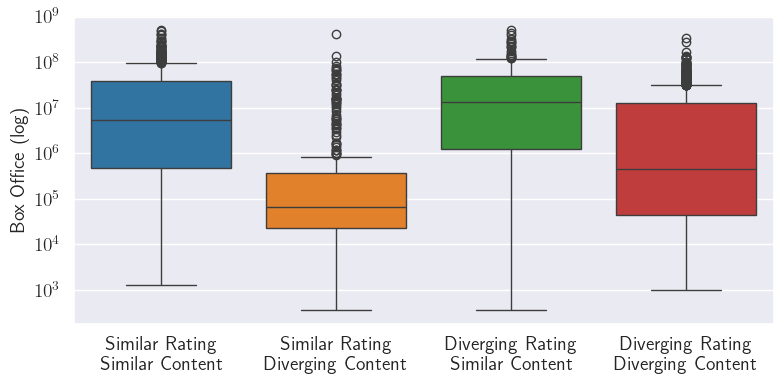

In [188]:
fig, ax = plt.subplots(1,1, figsize=(8,4))


# Boxplot
sns.boxplot(data=combined, x="group", y="boxOffice", hue="group", palette=group_palette, ax=ax)
ax.set_yscale("log")
ax.set_xlabel(None)
ax.set_ylabel("Box Office (log)", fontsize=14)

labels = [label.get_text().replace(",", "\n") for label in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.tick_params("x", labelsize=14, 
               #labelrotation=30
               )
ax.tick_params("y", labelsize=14)

plt.tight_layout()
plt.show()

In [189]:
print(combined_embeddings[combined_embeddings["CosineSimilarity"] <= 0.75].shape[0])

197
